# MNIST and CIFAR-10 With BNN

one of the thing you can make as a newbie with NN is a MNIST clasification. This file is praticly the same as the [Introduction to BNNs with Larq](https://docs.larq.dev/larq/tutorials/mnist/) with extra comment and gpu

## Setting up the environement

The LARQ library only compatitble with a certain version of tensorflow, hence also the cuda, so do keep in mind

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import larq as lq
print("Larq version:", lq.__version__)

import time


TensorFlow version: 2.9.0
Larq version: 0.13.3


### Check for CUDA

In [2]:
print("Is CUDA available:", tf.test.is_built_with_cuda())
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Is CUDA available: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-06-16 05:04:00.235376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-16 05:04:00.259770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-16 05:04:00.260085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Getting the data

### Cifar data

In [3]:
# Load the ImageNet-like dataset (e.g., CIFAR-10 as a smaller example)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

# Convert labels to one-dimensional arrays
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

### MNIST data

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

## Binary Resnet18

In [4]:
from larq_zoo.literature import BinaryResNetE18
import tensorflow as tf

# Resize and convert the dataset to match the expected input shape
train_images_resized = tf.image.resize(train_images, (32, 32))
test_images_resized = tf.image.resize(test_images, (32, 32))

# Load the BinaryResNetE18 model
model = BinaryResNetE18(input_shape=(32, 32, 3), include_top=True, weights=None, num_classes=10)

# Display the model summary
model.summary()



/home/zaim22/anaconda3/envs/larq-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-16 05:04:02.525480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-16 05:04:02.527170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-16 05:04:02.527460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be

Model: "binary_resnet_e_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 quant_conv2d (QuantConv2D)     (None, 32, 32, 64)   36864       ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['quant_conv2d[0][0]']           
 alization)                                                                      

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# model.load_weights("binary_resnet18_mnist.h5")

# Train the model
with tf.device('/GPU:0'):  # Use '/GPU:0' for the first GPU or '/CPU:0' for CPU
    start_time = time.time()
    model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split=0.2, verbose=1)
    end_time = time.time()
    print('Total Training Time: %.2f min' % ((end_time - start_time) / 60))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

2025-06-16 05:04:42.025402: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.
2025-06-16 05:04:42.488887: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/20


2025-06-16 05:04:46.432323: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-06-16 05:04:48.275251: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-16 05:04:48.610914: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-16 05:04:48.743536: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

  7/313 [..............................] - ETA: 1:35 - loss: 2.6759 - accuracy: 0.1641

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

313/313 [==============================] - 11s 34ms/step - loss: 1.4144 - accuracy: 0.6772
Test Accuracy: 0.6772000193595886


In [10]:
model.save("binary_resnet18_mnist.h5")
print("Model saved to binary_resnet18_mnist.h5")

Model saved to binary_resnet18_mnist.h5


In [11]:
lq.models.summary(model)

+binary_resnet_e_18 stats--------------------------------------------------------------------------------------+
| Layer                   Input prec.            Outputs   # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                               (bit)                          x 1       x 1     (kB)                          |
+--------------------------------------------------------------------------------------------------------------+
| input_1                           -    (-1, 32, 32, 3)         0         0        0           ?            ? |
| conv2d                            -   (-1, 32, 32, 64)         0      1728     6.75           0      1769472 |
| quant_conv2d                      1   (-1, 32, 32, 64)     36864         0     4.50    37748736            0 |
| batch_normalization               -   (-1, 32, 32, 64)         0       128     0.50           0            0 |
| add                               -   (-1, 32, 32, 64)         0         0        0           

1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


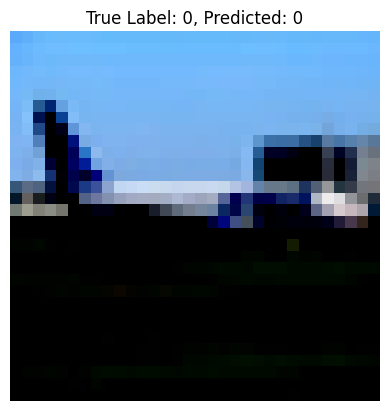

In [30]:
import numpy as np

import matplotlib.pyplot as plt

# Select a random test image
index = np.random.randint(0, len(test_images_resized))
image = test_images_resized[index]
true_label = test_labels[index]

# Predict the label
predictions = model.predict(image[np.newaxis, ...])
predicted_label = np.argmax(predictions)

# Display the image and prediction
plt.imshow(tf.squeeze(image).numpy(), cmap='gray')
plt.title(f"True Label: {true_label}, Predicted: {predicted_label}")
plt.axis('off')
plt.show()

In [ ]:
import netron


